<a id='main' name="main"></a>
# Viral Data Analysis

Date: 2021.10.11

Author: © 2021 Indrė Segalovičiūtė

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from [Our World in Data](https://ourworldindata.org/) to answer the following questions:


1. [What is the average percent of people who are unvaccinated, half vaccinated and fully vaccinated in 2021?](#Q1)
1. [What is the correlation between vaccinated/not vaccinated and amount of covid cases in 2021?](#Q2)
1. [ Is it possible to predict the future prognosis of COVID-19 cases based on vaccinations rates?](#Q3)

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

## Load the data

In [ ]:
import statistics
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import linear_model

Download the data to cache locally. Do this once (a day), and comment out, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [ ]:
import requests
fname = 'owid-covid-data.csv'
url = 'https://covid.ourworldindata.org/data/' + fname
r = requests.get(url)
open(fname, 'wb').write(r.content)

33601189

Load the file to Pandas.

In [ ]:
#url = " "
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
original_df = pd.read_csv(url, parse_dates=[3])
original_df.info()

# Filter only 2021 data and fill nullable values
original_df = original_df[(original_df['date'] > '31/12/2020')]
original_df.fillna(original_df.mean(), inplace=True)
original_df['people_unvaccinated'] = original_df.apply(lambda row: row.population - row.people_vaccinated, axis=1)


First of all, there is created dataset for 1 and 2 tasks. New dataset will have max 356 rows for each day in 2021 years. Other colums will be sumsor means of countries vaues

In [ ]:
# Because these columns will be used, their max value set to 100%
original_df['people_vaccinated_per_hundred'] = np.where(original_df.people_vaccinated_per_hundred > 100, 100, original_df.people_vaccinated_per_hundred)  
original_df['people_fully_vaccinated_per_hundred'] = np.where(original_df.people_fully_vaccinated_per_hundred > 100, 100, original_df.people_fully_vaccinated_per_hundred)  

# Create new dataset for 1-2 problems
df = pd.pivot_table(
   original_df,
   index=['date'],
   aggfunc={
       'people_vaccinated_per_hundred': np.mean,
       'people_fully_vaccinated_per_hundred': np.mean,
       'people_vaccinated': np.sum,
       'people_unvaccinated': np.sum,
       'people_fully_vaccinated': np.sum,
       'new_cases': np.sum,
       'new_cases_per_million': np.mean,
       'population': np.sum,
       'iso_code': len,
       'total_cases': np.sum}
).rename(columns={'ID': 'count'})

df['people_unvaccinated_per_hundred'] = df.apply(lambda row: 100 - row.people_vaccinated_per_hundred, axis=1)


[back to the top](#main)
<a id='Q1' name='Q1'></a>
## 1. What is the average percent of people who are unvaccinated, half vaccinated and fully vaccinated in 2021?

Here we can see average percent of vaccinated and fully vaccinated people and 2021 year graph of these people

In [ ]:
print('All data:')
print('Average percent of vaccinated people:', df["people_vaccinated_per_hundred"].iloc[-1])
print('Average percent of fully vaccinated people:', df["people_fully_vaccinated_per_hundred"].iloc[-1])


All data:
Average percent of vaccinated people: 35.14317816976988
Average percent of fully vaccinated people: 28.103017012640247


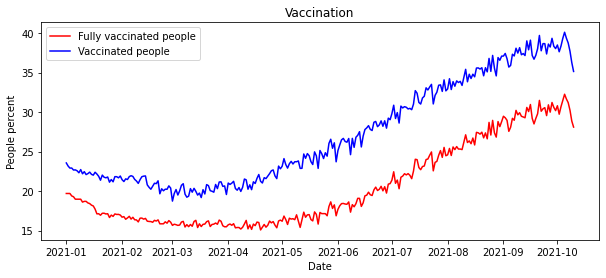

In [ ]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.plot(df.index, df[['people_fully_vaccinated_per_hundred']].to_numpy(), color='r')
plt.plot(df.index, df[['people_vaccinated_per_hundred']].to_numpy(), color='b')

plt.xlabel('Date')
plt.ylabel('People percent')

plt.legend(['Fully vaccinated people', 'Vaccinated people'])
plt.title('Vaccination')
plt.show()

Below we can see every month statistics of vaccintation:


In [ ]:
data_month = df.resample('M').mean()
data_month

,iso_code,new_cases,new_cases_per_million,people_fully_vaccinated,people_fully_vaccinated_per_hundred,people_unvaccinated,people_vaccinated,people_vaccinated_per_hundred,population,total_cases,people_unvaccinated_per_hundred
date,,,,,,,,,,,
2021-01-31,203.935484,2.052799e+06,128.385388,4.394862e+09,18.037350,1.789259e+10,6.314286e+09,22.165284,2.420688e+10,3.118250e+08,77.834716
2021-02-28,215.071429,1.425555e+06,105.224896,4.130574e+09,16.317127,1.806783e+10,6.186650e+09,21.037587,2.425448e+10,3.870037e+08,78.962413
2021-03-31,217.064516,1.709523e+06,127.719067,3.998392e+09,15.810237,1.850346e+10,5.751084e+09,20.081373,2.425454e+10,4.318247e+08,79.918627
2021-04-30,221.466667,2.567459e+06,127.120858,4.028669e+09,15.702292,1.818320e+10,6.071710e+09,21.330234,2.425491e+10,5.035873e+08,78.669766
2021-05-31,224.000000,2.163746e+06,104.674931,4.249254e+09,16.849875,1.755789e+10,6.697200e+09,24.187309,2.425509e+10,5.795597e+08,75.812691
2021-06-30,227.200000,1.389850e+06,80.620459,4.661584e+09,19.210085,1.573947e+10,8.515732e+09,27.328623,2.425520e+10,6.303992e+08,72.671377
2021-07-31,229.000000,1.810229e+06,99.449191,5.431243e+09,23.038322,1.416937e+10,1.008583e+10,31.572459,2.425520e+10,6.745012e+08,68.427541
2021-08-31,227.903226,2.218344e+06,128.558074,7.331585e+09,26.649520,1.287720e+10,1.137801e+10,34.882900,2.425521e+10,7.280860e+08,65.117100
2021-09-30,224.466667,1.822278e+06,136.108939,9.325742e+09,29.759987,1.073532e+10,1.350522e+10,37.751360,2.424054e+10,7.745308e+08,62.248640


Text(0.5, 0, 'Date')

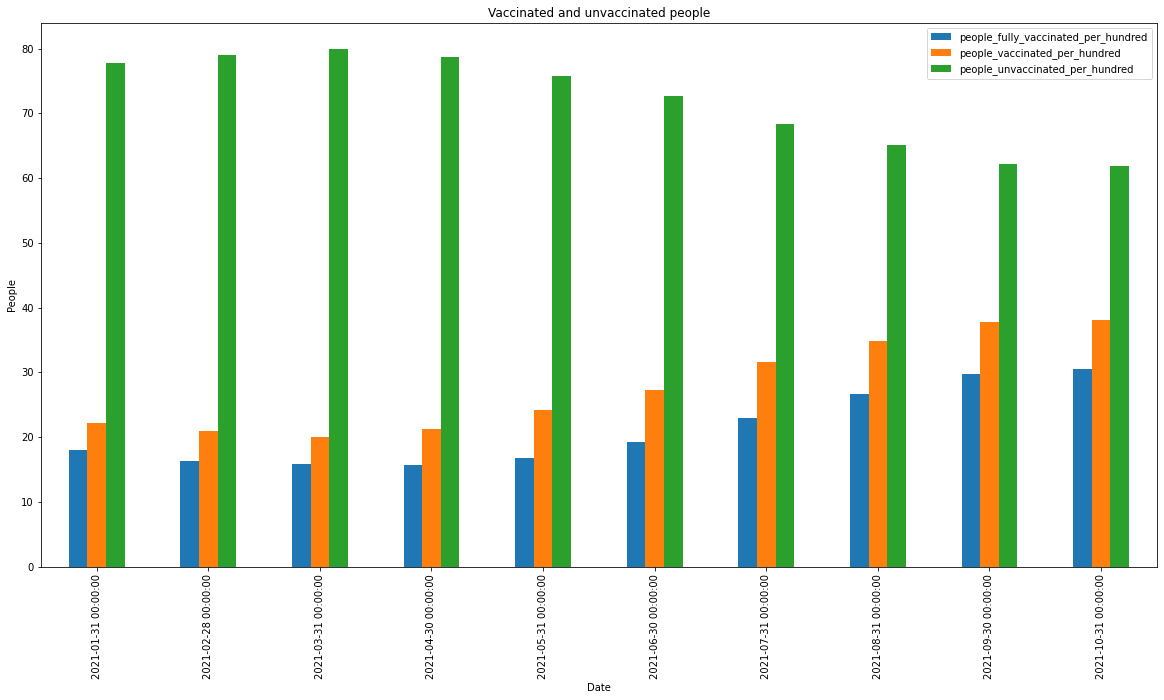

In [ ]:
data_month.plot(y=[ "people_fully_vaccinated_per_hundred", "people_vaccinated_per_hundred", "people_unvaccinated_per_hundred"], kind="bar", figsize=(20,10), title='Vaccinated and unvaccinated people')
plt.ylabel('People')
plt.xlabel('Date')

**Conclusion**: right now more than third people are vaccinated and this number is rising.

[back to the top](#main)
<a id='Q2' name='Q2'></a>
## 2. What is the correlation between vaccinated/not vaccinated and amount of covid cases in 2021?

In [ ]:
print('Correliation between unvaccinated people and total cases:', df['people_unvaccinated'].corr(df['total_cases']))
print('Correliation between vaccinated people and total cases:', df['people_vaccinated'].corr(df['total_cases']))

Correliation between unvaccinated people and total cases: -0.8668976377024002
Correliation between vaccinated people and total cases: 0.8697076155672897


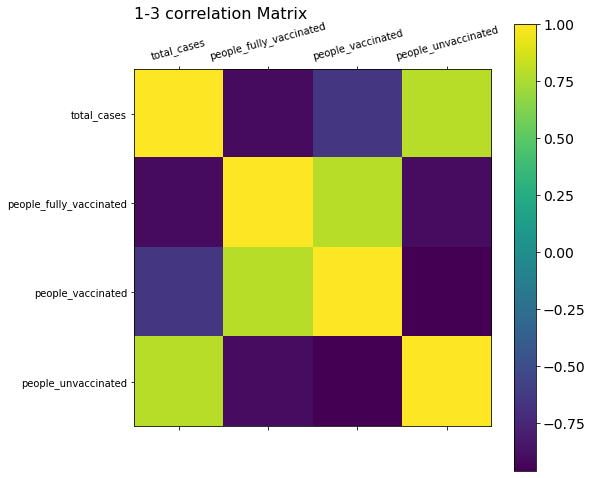

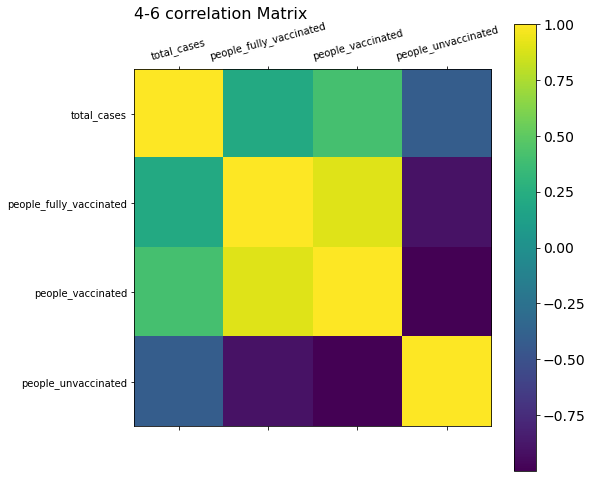

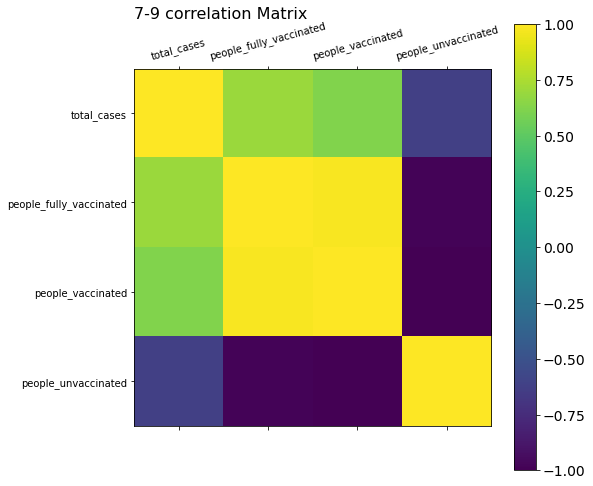

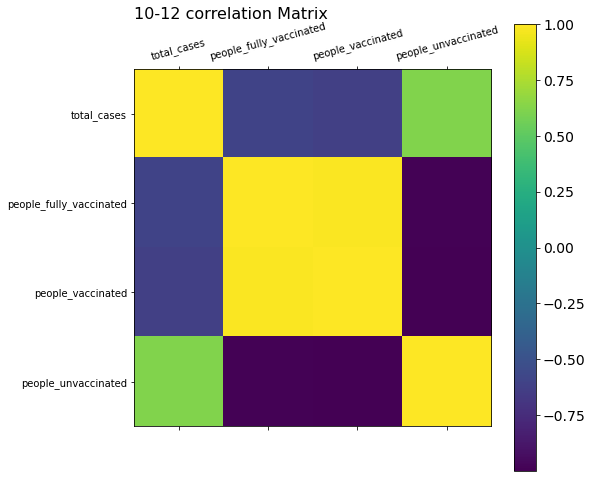

In [ ]:
corr_df = df[['total_cases', 'people_fully_vaccinated', 'people_vaccinated', 'people_unvaccinated']].copy()
for i in range(1,12, 3):
  start_date = f'2021-{i}-1'
  end_date = f'2021-{i+1}-1'
  after_start_date = corr_df.index >= start_date
  before_end_date = corr_df.index < end_date
  between_two_dates = after_start_date & before_end_date
  filtered_dates = corr_df.loc[between_two_dates]
  
  matfig = plt.figure(figsize=(8,8))
  plt.matshow(filtered_dates.corr(), fignum=matfig.number)
  plt.xticks(range(filtered_dates.select_dtypes(['number']).shape[1]), filtered_dates.select_dtypes(['number']).columns, fontsize=10, rotation=15)
  plt.yticks(range(filtered_dates.select_dtypes(['number']).shape[1]), filtered_dates.select_dtypes(['number']).columns, fontsize=10)
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=14)
  plt.title(f'{i}-{i+2} correlation Matrix', fontsize=16, loc='left', pad=50)


**Conclusion**: as we can see from correlation plots above, vaccinated, unvaccinated people and cases count have different correlation at different time:


*   In the first and last trimesters of 2021 we have a strong correlation between cases and unvaccinated people while cases count and vaccinated people count have low correlation
*   In the second and third trimesters of 2021 situation is oposite. Correlation between cases and vaccinated people is growing while correlation between cases and unvaccinated people is decrasing.

But looking for the all the data, correlation between cases and vaccinated people is stronger.

[back to the top](#main)
<a id='Q3' name='Q3'></a>
## 3.  Is it possible to predict the future prognosis of COVID-19 cases based on vaccinations rates?  

To answer this question we will try to predict the future prognosis of COVID-19 cases based on vaccinations rates in different continents using linear regression model, because different people and their mentality could have had and influence to cases count.
We will try to predict cases for each continent.

https://scikit-learn.org/stable/modules/tree.html

https://scikit-learn.org/stable/modules/clustering.html#k-means

https://scikit-learn.org/stable/modules/svm.html#svm-regression

Firstly, there is created function, which prepares continent data for model. 



In [ ]:
def get_dataset(continent, filter_date=None):
  df_all =  original_df[(original_df.location == continent)]
  if filter_date: 
    df_all = df_all[(df_all['date'] > filter_date)]
  pd.DataFrame(df_all).fillna(df_all.mean(), inplace=True)

  df_x = df_all[['date', 'total_vaccinations', 'human_development_index']].copy()
  df_y = df_all[['total_cases',]].copy()
  df_x = df_x.set_index('date')

  return df_x, df_y

Second, we create function for prediction, which splits data to train and test sets, learn the model, tries to predict cases count and dispaly results.




In [ ]:
def predit_model(df_x, df_y, model, continent):
  x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size=0.85, shuffle=False)

  model = model.fit(x_train, y_train)

  y_results = model.predict(x_test)

  plt.rcParams["figure.figsize"] = (10, 4)
  plt.plot(x_train.index, y_train[['total_cases']].to_numpy())
  plt.plot(x_test.index, y_results, linestyle='dashed', color='r')
  plt.plot(x_test.index, y_test, linestyle='dashed', color='g')

  plt.title(continent)
  plt.xlabel('Date')
  plt.ylabel('Total cases')
  plt.legend(['Real cases (current)', 'Prediction', 'Real cases (future)'])
  plt.show()
  

Here we create *LinearRegression* model and try to predict COVID-19 cases for each continents



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


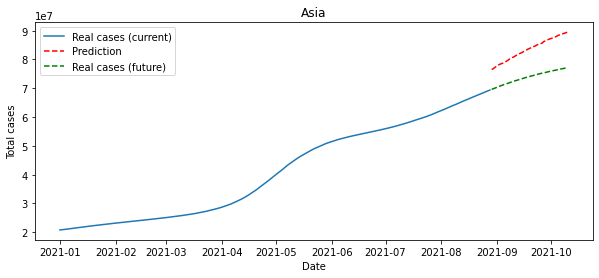

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


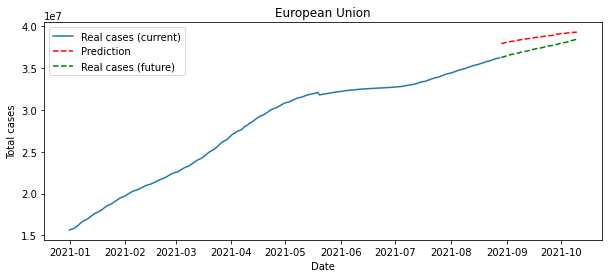

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


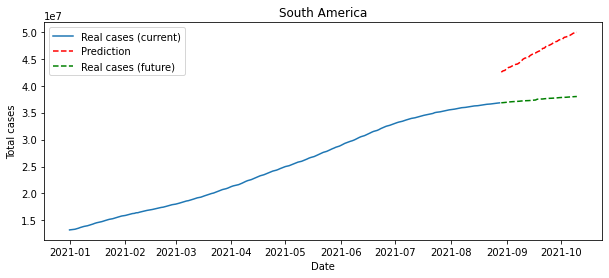

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


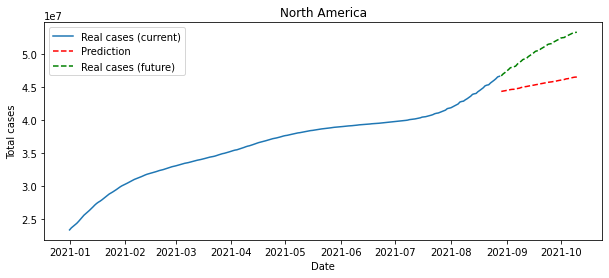

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


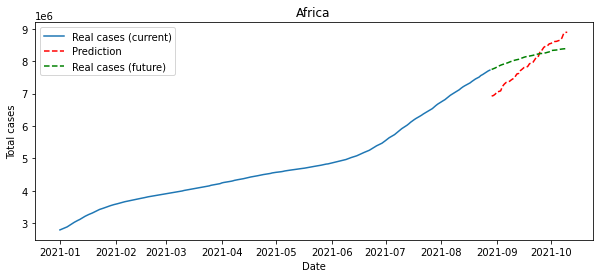

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


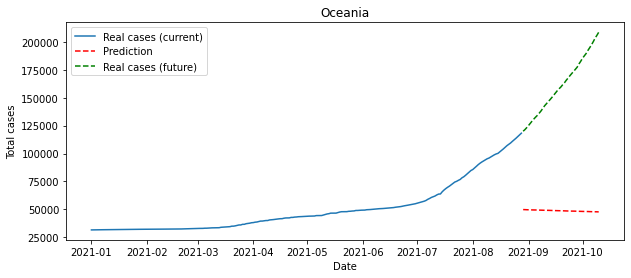

In [ ]:
model = linear_model.LinearRegression(n_jobs=10)

continents = ['Asia', 'European Union', 'South America', 'North America', 'Africa', 'Oceania'] 
for continent in continents:
  df_x, df_y = get_dataset(continent)
  predit_model(df_x, df_y, model, continent)

As we can see here, redictions are not very accurate, becase COVID-1 cases are rising slowly and evenly for more than half year, but since september is increase rapidly. For example in Asia or Europe total cases are hingh for most of the time, so prediction show similar increasing. But for North America or Oceania teh model do not catch the cases rising and predicts much lower cases.

That is why below we are trying to predict cases not for whole year, but only for the second part:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


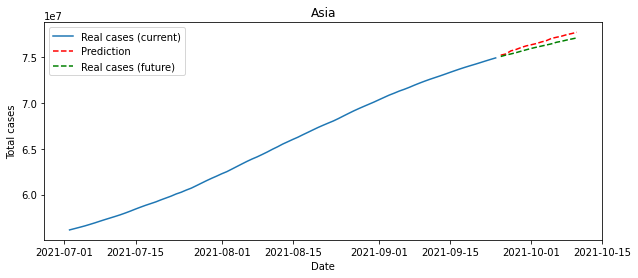

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


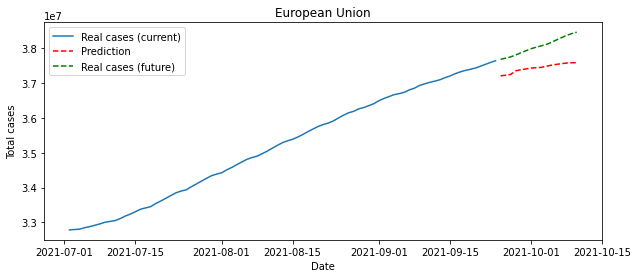

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


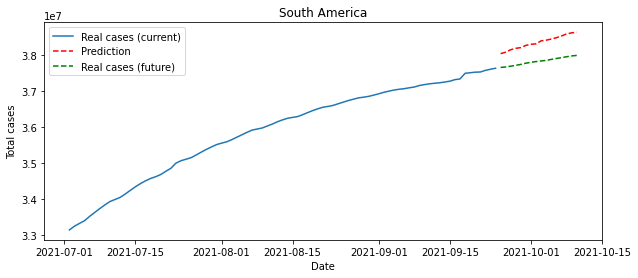

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


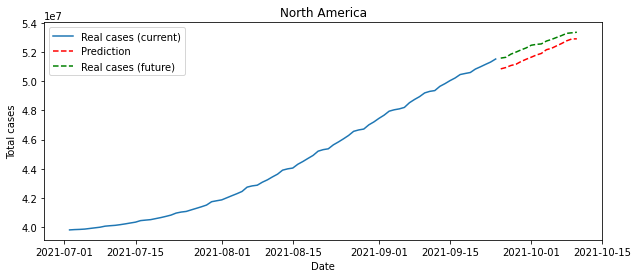

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


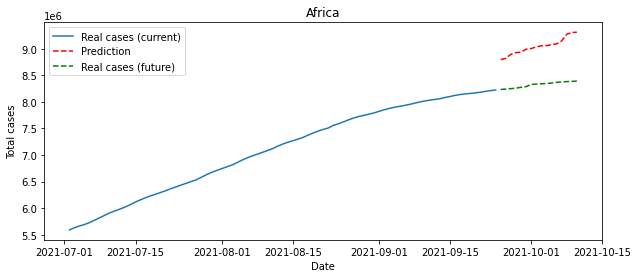

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


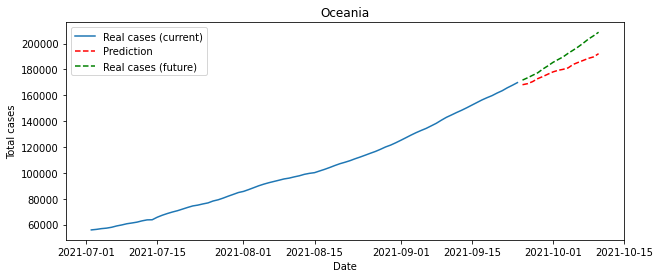

In [ ]:
model = linear_model.LinearRegression(n_jobs=10)

continents = ['Asia', 'European Union', 'South America', 'North America', 'Africa', 'Oceania'] 
for continent in continents:
  df_x, df_y = get_dataset(continent, '7/1/2021')
  predit_model(df_x, df_y, model, continent)

Here we can see much more acurate results because the data set is more suitable for the task.

**Conclusion**: with the correct data set we can predict future cases using linear regresion. Of course, not always result isvery accurate, but is shows kind a realictic prognosis.